In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Learning/csv files/hearing_test.csv')

###our data set is about ppl age and their physical health score and their ability to hear high pitch sound 1 for true and 0 for false , our objective is to build a model to predict the ability to hear high pitch sound based on their age and physical score

In [ ]:
df.head()

,age,physical_score,test_result
0,33.0,40.7,1
1,50.0,37.2,1
2,52.0,24.7,0
3,56.0,31.0,0
4,35.0,42.9,1


#Exploratory Data Analysis

In [ ]:
df['test_result'].value_counts()

,count
test_result,
1,3000
0,2000


<Axes: xlabel='test_result', ylabel='age'>

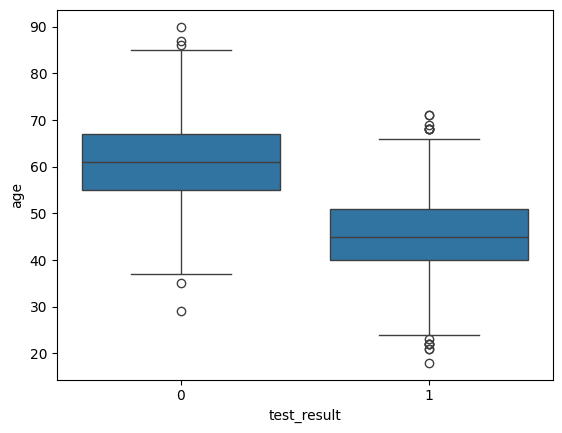

In [ ]:
sns.boxplot(y='age',x='test_result',data=df)

###from this visualization we can see that ppl with higher age group are more prone to fail the test

### Note:- for a categorical column we should use box plot


<Axes: xlabel='test_result', ylabel='physical_score'>

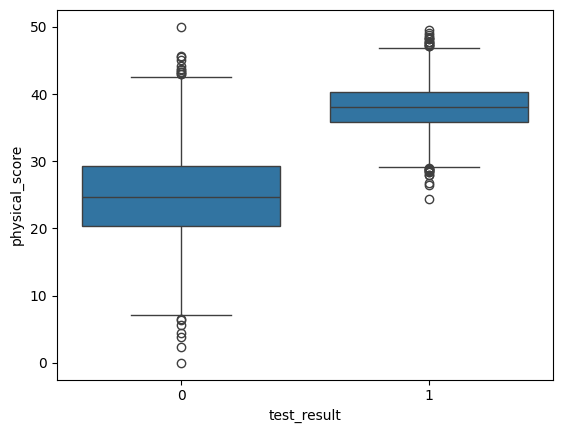

In [ ]:
sns.boxplot(y='physical_score',x='test_result',data=df)

###from this visualization we can see that ppl with higher physical score are more prone to pass the test

<Axes: xlabel='age', ylabel='physical_score'>

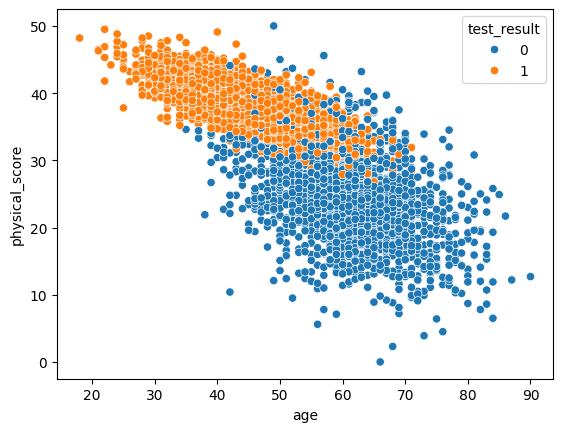

In [ ]:
sns.scatterplot(y='physical_score',x='age',data=df,hue='test_result')

###observation :- As ppl grows older , their physical score goes down , so we have a negative correlation here

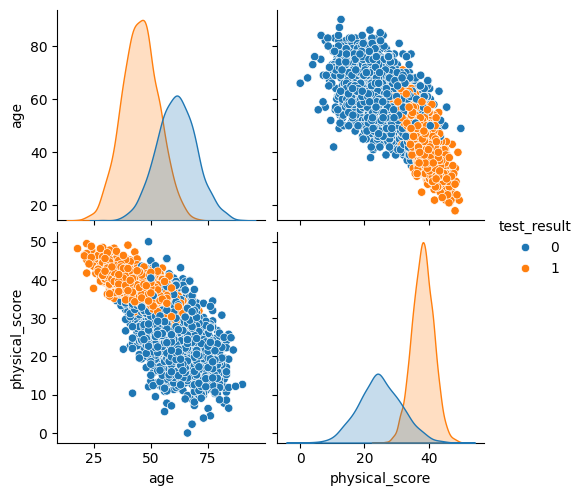

In [ ]:
sns.pairplot(data=df,hue='test_result')

####our data has very less overlapping that means our model should give very good results for this

In [ ]:
df.corr() #negative correlation as expected

,age,physical_score,test_result
age,1.000000,-0.782146,-0.683171
physical_score,-0.782146,1.000000,0.792716
test_result,-0.683171,0.792716,1.000000


#Train | Test | Split

In [ ]:
X = df.drop('test_result',axis= 1)
Y = df['test_result']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=101)

####Now we will scale and fit the training data at the same time

In [ ]:
sc = StandardScaler()


In [ ]:
sc_X_train = sc.fit_transform(X_train) #scaling and training model on the train data
sc_X_test = sc.transform(X_test) #scaling test data

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb_model = GaussianNB()

In [ ]:
nb_model.fit(sc_X_train,Y_train) #we don't scale the label (Y part)

GaussianNB()

In [ ]:
Y_pred = nb_model.predict(sc_X_test)

In [ ]:
Y_proba = nb_model.predict_proba(sc_X_test) #this gives us the probability of the values to belong with the chosen category

###Let's try on new data now

In [ ]:
nb_model.predict_proba(sc.transform([[50,32],[32,54]])) #working fine

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.30777699, 0.69222301],
       [0.02004748, 0.97995252]])

###we can use other model as well to do the same thing and will still get the same results for example logistic Regression model

#Model Test

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay,RocCurveDisplay ,PrecisionRecallDisplay

In [ ]:
accuracy_score(Y_test,Y_pred) #comparing our Y test data and the model's predicted data to check the accuracy our model

0.915

In [ ]:
confusion_matrix(Y_test,Y_pred)

array([[339,  49],
       [ 36, 576]])

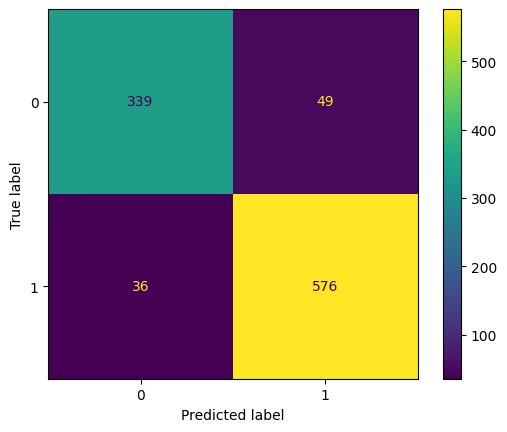

In [ ]:
cm = confusion_matrix(Y_test,Y_pred)
ConfusionMatrixDisplay(cm).plot()

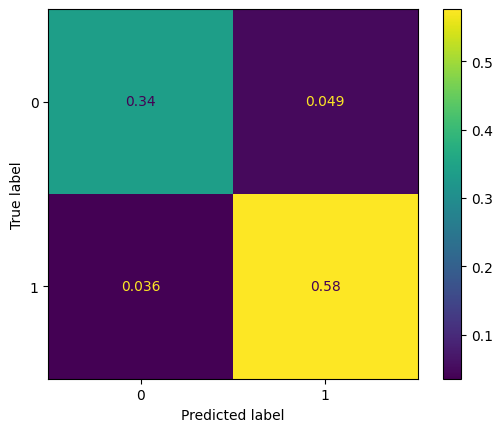

In [ ]:
cm = confusion_matrix(Y_test,Y_pred,normalize='all') #we can normalise our data as well
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       388
           1       0.92      0.94      0.93       612

    accuracy                           0.92      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.92      0.91      1000



#ROC curves and AUC

In [ ]:
from sklearn import metrics

In [ ]:
Y_score = Y_proba[:,1]
metrics.roc_curve

<function sklearn.metrics._ranking.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)>

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


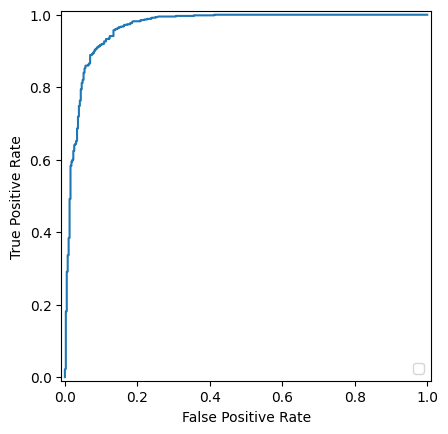

In [ ]:
fpr,tpr,threshold = metrics.roc_curve(Y_test,Y_score)
RocCurveDisplay(fpr = fpr,tpr = tpr).plot()

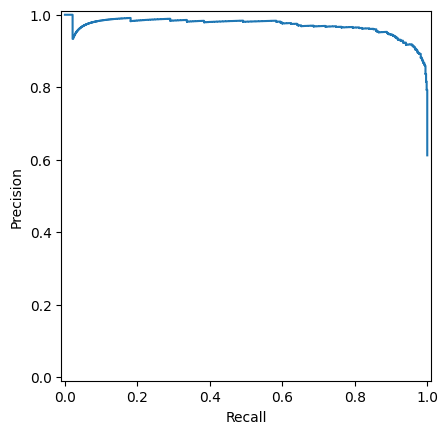

In [ ]:
precison , recall , threshold = metrics.precision_recall_curve(Y_test,Y_score)
PrecisionRecallDisplay(precision=precison,recall=recall).plot()

##Chebyshev Classifier

In [ ]:
class ChebyshevClassifier:

  def __init__(self,agg='mean',k_threshold=None,eps=.000001):
    self.agg = agg
    self.k_threshold = k_threshold
    self.eps = eps
    self.class_stats = {}
    self.classes = None

  def fit(self,X,y):
    X,y = np.asarray(X), np.asarray(y)
    self.classes_ = np.unique(y)

    for c in self.classes_:
      Xc = X[y==c]
      mu = Xc.mean(axis=0)
      var = Xc.var(axis=0)
      var[var < self.eps] = self.eps
      sigma = np.sqrt(var)
      self.class_stats[c] = {'mu':mu, 'sigma':sigma}
    return self

  def _score_sample(self,x):
    scores = {}
    for c,stats in self.class_stats.items():
      z = np.abs(x - stats['mu'])/stats['sigma']
      agg_z = z.mean() if self.agg == 'mean' else z.max()
      scores[c] = agg_z
    return scores

  def predict(self,X):
    preds = []
    outlier_flags = []

    for x in X:
      scores = self._score_sample(x)
      best_c = min(scores, key=scores.get)

      preds.append(best_c)

      best_z = scores[best_c]
      if (self.k_threshold is not None) and (best_z > self.k_threshold):
        outlier_flags.append(1)
      else:
        outlier_flags.append(0)
    return np.array(preds), np.array(outlier_flags)

In [ ]:
cb = ChebyshevClassifier()

In [ ]:
cb.fit(sc_X_train,Y_train)

In [ ]:
y_pred_cb, outliers = cb.predict(sc_X_test)

In [ ]:
y_pred_cb

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,

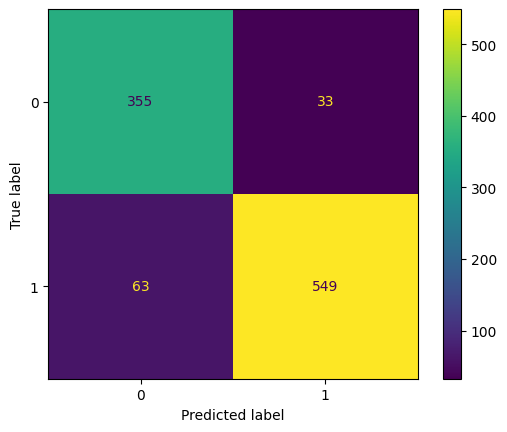

In [ ]:
cm = confusion_matrix(Y_test,y_pred_cb)
ConfusionMatrixDisplay(cm).plot()